In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [2]:
rng = np.random.RandomState(42)

In [3]:
n_samples = int(1e5)
n_signal_samples = int(0.9 * n_samples)
n_noise_samples = n_samples - n_signal_samples
n_features = 2

signal, labels = make_blobs(n_samples=n_signal_samples, n_features=n_features,
                            cluster_std=0.1, centers=500,
                            random_state=rng)
noise = rng.uniform(low=-15, high=15, size=(n_noise_samples, n_features))

data = np.vstack([signal, noise])
labels = np.concatenate([labels, [-1] * noise.shape[0]])
data, labels = shuffle(data, labels, random_state=rng)

In [63]:
def plot_data_with_labels(data, labels, alpha=0.3, cm=plt.cm.prism, subsample=int(5e4),
                          title=None, random_state=0):
    n_samples = data.shape[0]
    
    if title is None:
        title = "Scatter plot of the first 2 dimensions"

    if n_samples > subsample:
        idx = shuffle(np.arange(n_samples), random_state=random_state)[:subsample]
        data = data[idx]
        labels = labels[idx]

    plt.figure(figsize=(10, 10))
    plt.xlim(-12, 12)
    plt.ylim(-12, 12)

    unique_labels = np.unique(labels)
    colors = cm(np.linspace(0, 1, len(unique_labels)))
    for l, c in zip(unique_labels, colors):
        if l == -1:
            c = 'b'
        data_l = data[labels == l]
        plt.scatter(data_l[:, 0], data_l[:, 1], alpha=alpha,
                    facecolors=c, edgecolors='none')
    plt.title(title)

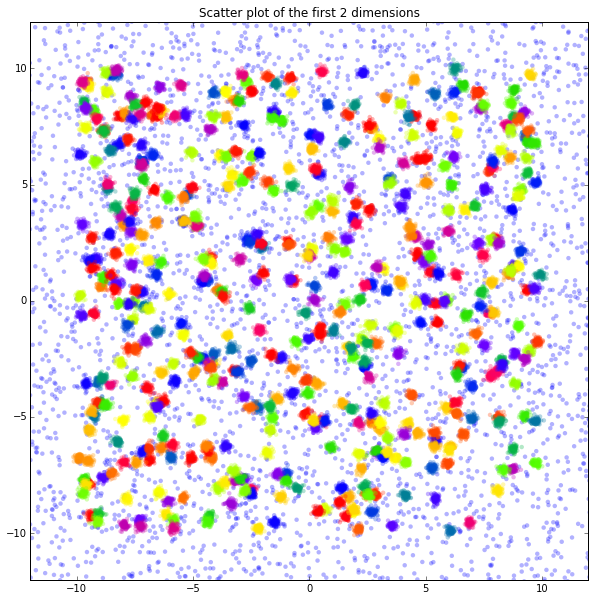

In [64]:
plot_data_with_labels(data, labels)

## DBSCAN

In [65]:
%%time
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, algorithm='kd_tree')
dbscan_labels = dbscan.fit_predict(data)

CPU times: user 1.36 s, sys: 28.6 ms, total: 1.38 s
Wall time: 1.39 s


In [66]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("NMI DBSCAN: %0.3f"
      % normalized_mutual_info_score(labels, dbscan_labels))
print("ARI DBSCAN: %0.3f"
      % adjusted_rand_score(labels, dbscan_labels))

NMI DBSCAN: 0.882
ARI DBSCAN: 0.502


In [67]:
unique_dbscan_labels = np.unique(dbscan_labels)
print(len(unique_dbscan_labels))

445


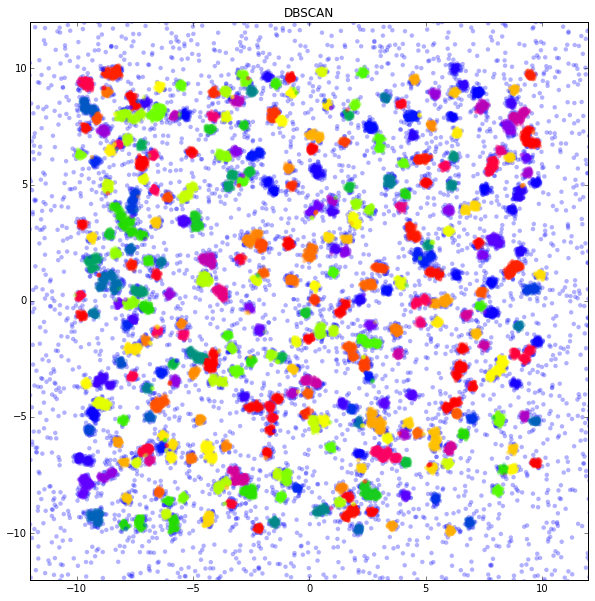

In [68]:
plot_data_with_labels(data, dbscan_labels, title='DBSCAN')

##  Mini Batch K-Means

In [70]:
%%time
from sklearn.cluster import MiniBatchKMeans

mbkmeans = MiniBatchKMeans(n_clusters=500,
                           init_size=int(1e4),
                           batch_size=int(1e3))
mbkmeans_labels = mbkmeans.fit_predict(data)

CPU times: user 7.51 s, sys: 411 ms, total: 7.92 s
Wall time: 7.62 s


In [71]:
print("NMI MB K-Means: %0.3f"
      % normalized_mutual_info_score(labels, mbkmeans_labels))
print("ARI MB K-Means: %0.3f"
      % adjusted_rand_score(labels, mbkmeans_labels))

NMI MB K-Means: 0.890
ARI MB K-Means: 0.212


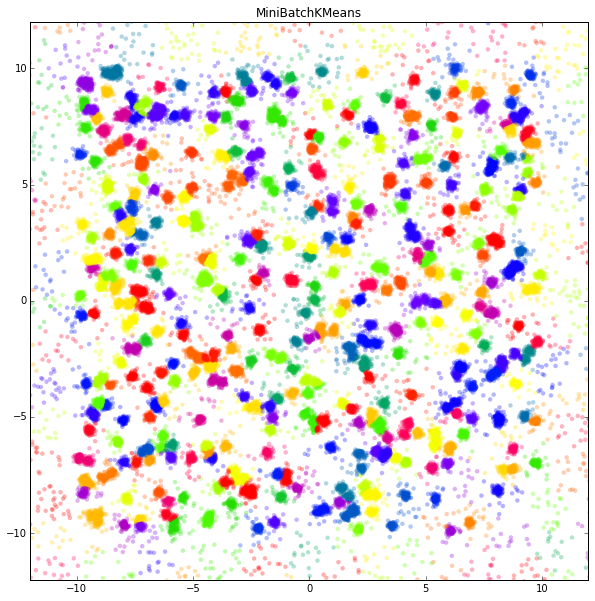

In [72]:
plot_data_with_labels(data, mbkmeans_labels, title='MiniBatchKMeans')

## Birch

In [87]:
%%time
from sklearn.cluster import Birch

birch = Birch(threshold=0.5, n_clusters=500)
birch_labels = birch.fit_predict(data)

CPU times: user 6.74 s, sys: 381 ms, total: 7.12 s
Wall time: 6.83 s


In [100]:
print("NMI Birch: %0.3f"
      % normalized_mutual_info_score(labels, birch_labels))
print("ARI Birch: %0.3f"
      % adjusted_rand_score(labels, birch_labels))

NMI Birch: 0.832
ARI Birch: 0.170


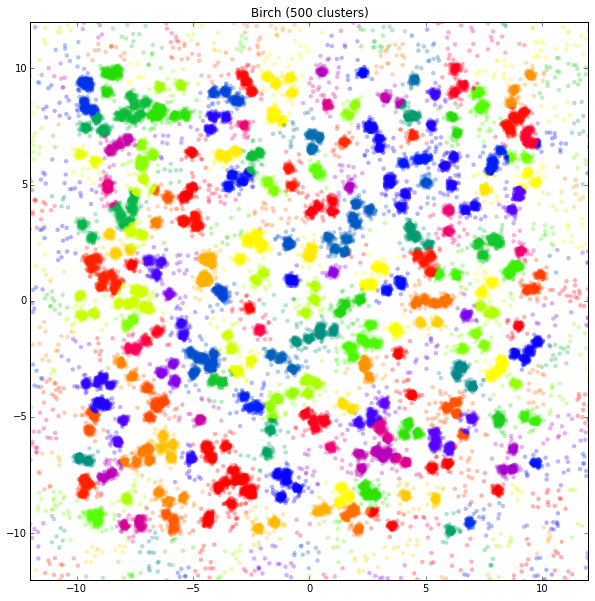

In [94]:
plot_data_with_labels(data, birch_labels, title='Birch (500 clusters)')

In [90]:
print(len(birch.subcluster_centers_))

1065


In [101]:
%%time
birch.set_params(n_clusters=10)
birch.partial_fit()

CPU times: user 753 ms, sys: 12.4 ms, total: 766 ms
Wall time: 774 ms


In [102]:
%%time
birch_labels_small = birch.predict(data)

CPU times: user 1.16 s, sys: 318 ms, total: 1.48 s
Wall time: 1.13 s


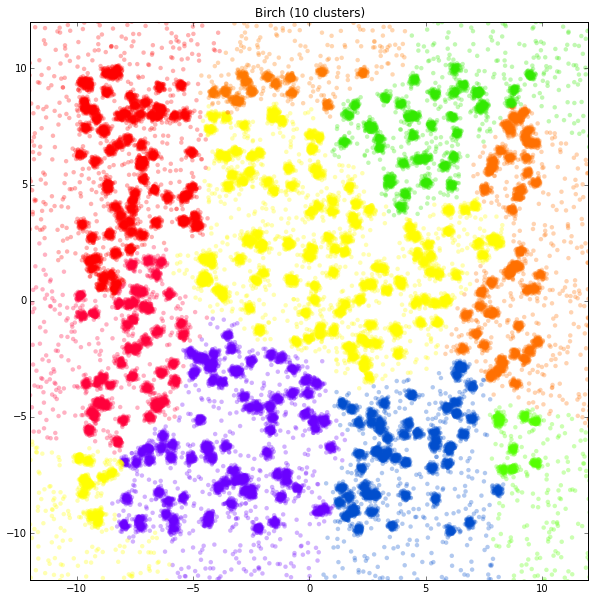

In [103]:
plot_data_with_labels(data, birch_labels_small,
                      title='Birch (10 clusters)')

## Batch K-Means

In [20]:
# %%time
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=500, n_jobs=10)
# kmeans_labels = kmeans.fit_predict(data)

In [21]:
# print("NMI K-Means: %0.3f"
#       % normalized_mutual_info_score(labels, kmeans_labels))
# print("ARI  K-Means: %0.3f"
#       % adjusted_rand_score(labels, kmeans_labels))

In [22]:
# plot_data_with_labels(data, kmeans_labels)

In [34]:
data_source = None

def iter_chunks(data_source, batch_size=1000):
    for i in range(int(1e5) // batch_size):
        yield np.random.randn(batch_size, 2)

In [80]:
from sklearn.cluster import Birch

birch = Birch(threshold=0.1, n_clusters=None)

for X_chunk in iter_chunks(data_source, batch_size=10000):
    birch.partial_fit(X_chunk)

In [81]:
print(len(birch.subcluster_centers_))

1437


In [82]:
%%time
birch.set_params(n_clusters=10)
birch.partial_fit()  # trigger the global clustering

CPU times: user 1.83 s, sys: 31.1 ms, total: 1.86 s
Wall time: 1.86 s


In [83]:
len(np.unique(birch.predict(data)))

10

In [84]:
%%time
birch.set_params(n_clusters=3)
birch.partial_fit()  # trigger the global clustering

CPU times: user 1.86 s, sys: 30.3 ms, total: 1.89 s
Wall time: 1.93 s


In [85]:
len(np.unique(birch.predict(data)))

3